In [1]:
import os
from tabulate import tabulate
from nilearn import plotting
from nilearn import image
from nilearn.image import math_img, resample_to_img, get_data
from nilearn.datasets import fetch_atlas_harvard_oxford
from nilearn.plotting import plot_stat_map, view_img
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp, pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
import ants
import nibabel as nib

In [2]:
# Fetch the Harvard-Oxford atlas
ATLAS = fetch_atlas_harvard_oxford('cort-maxprob-thr25-1mm')
# Load the atlas image
ATLAS_IMAGE = image.load_img(ATLAS.maps)
ATLAS_DATA = get_data(ATLAS_IMAGE)
# Extract region names from the atlas
LABEL_NAMES = ATLAS['labels']
# Extract unique region labels from the atlas
REGION_LABELS = np.unique(ATLAS_DATA)

[get_dataset_dir] Dataset found in /Users/mayerunterberg/nilearn_data/fsl


In [3]:
def get_subject_file_pairs(data_dir, subjectDF):
    file_pairs = []
    for subject in os.listdir(data_dir):
        subject_path = os.path.join(data_dir, subject)

        # Skip non-directories or irrelevant files
        if not os.path.isdir(subject_path) or subject.startswith('.') or subject == 'derivatives':
            continue

        for index, row in subjectDF.iterrows():
            subject = row['participant_id']
            subject_path = os.path.join(data_dir, f"sub-{subject:03d}")

            # Locate BL and FU files
            baseline_file = os.path.join(subject_path, 'ses-BL', 'anat', f"sub-{subject:03d}_ses-BL_T1w.nii.gz")
            followup_file = os.path.join(subject_path, 'ses-FU', 'anat', f"sub-{subject:03d}_ses-FU_T1w.nii.gz")

            # Verify that both files exist
            if os.path.exists(baseline_file) and os.path.exists(followup_file):
                # Add the file paths to the DataFrame
                subjectDF.at[index, 'Baseline File Path'] = 'Data/' + os.path.relpath(baseline_file, data_dir)
                subjectDF.at[index, 'Followup File Path'] = 'Data/' + os.path.relpath(followup_file, data_dir)
            else:
                print(f"Skipping subject {subject}: missing files.")

In [4]:
participants_df = pd.read_csv('Data/participants.tsv', sep="\t")
# Add columns for file paths
filePaths = ['Baseline File Path', 'Followup File Path']
for label in filePaths:
    participants_df[label] = None
get_subject_file_pairs('Data', participants_df)
for label in LABEL_NAMES:
    participants_df[label + ' Change'] = None

In [5]:
def findDifferingAreas(index, regionList, img1, img2):
    # Creates the difference map
    diff = image.math_img("img1 - img2", img1=img1, img2=img2)
    diff_data = get_data(diff)
    # Loop through each region to compute statistics
    for label in REGION_LABELS:
        regionMask = (ATLAS_DATA == label)
        regionChanges = diff_data[regionMask]
        region_mean = round(float(np.mean(regionChanges)), 2)
        if 0 <= label < len(LABEL_NAMES):
            region_name = LABEL_NAMES[label]  # Adjust for 1-based indexing
        else:
            region_name = "Unknown Region"
        # Insert the region_mean into the correct column and row in the DataFrame
        participants_df.loc[index, f"{region_name} Change"] = region_mean

In [18]:
def register_and_convert_to_nifti(fixed_image, moving_image, subject_id, session, transform_type='Rigid'):
    # Perform the registration
    registered = ants.registration(
        fixed=fixed_image,
        moving=moving_image,
        type_of_transform=transform_type
    )['warpedmovout']
    # Write out to disk
    out_path = f"output/registered_output_sub-{subject_id}_ses-{session}.nii.gz"
    ants.image_write(registered, out_path)
    return nib.load(out_path)

def loadImage(imgPath, subject_id, session):
    atlasPath = '/Users/mayerunterberg/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-1mm.nii.gz'
    atlas_image = ants.image_read(atlasPath)
    ants_img = ants.image_read(imgPath)
    
    # Register and convert to NIfTI
    nifti = register_and_convert_to_nifti(
            fixed_image=atlas_image,
            moving_image=ants_img,
            subject_id=subject_id,
            session=session
        )
        
    img_resampled = resample_to_img(
        source_img=nifti,
        target_img=ATLAS_IMAGE,
        force_resample=True,
        copy_header=True,
        interpolation='nearest'
    )
    return img_resampled

In [33]:
bu = participants_df[participants_df['participant_id'] == 112]['Baseline File Path'].iloc[0]
fu = participants_df[participants_df['participant_id'] == 112]['Followup File Path'].iloc[0]
baseLine = loadImage(bu, 112, 'BL')
followUp = loadImage(fu, 112, 'FU')
findDifferingAreas(27, participants_df, baseLine, followUp)
participants_df[participants_df['participant_id'] == 112]

,participant_id,group,gender,age at baseline,age at onset first CB use,age at onset frequent CB use,cudit total baseline,cudit total follow-up,audit total baseline,audit total follow-up,...,Temporal Occipital Fusiform Cortex Change,Occipital Fusiform Gyrus Change,Frontal Opercular Cortex Change,Central Opercular Cortex Change,Parietal Opercular Cortex Change,Planum Polare Change,Heschl's Gyrus (includes H1 and H2) Change,Planum Temporale Change,Supracalcarine Cortex Change,Occipital Pole Change
27,112,CB,male,20.5,15.0,17.0,21,22,9,15,...,-225.78,-224.44,-61.59,-30.95,-125.85,20.25,-185.4,-178.2,-297.71,-199.0


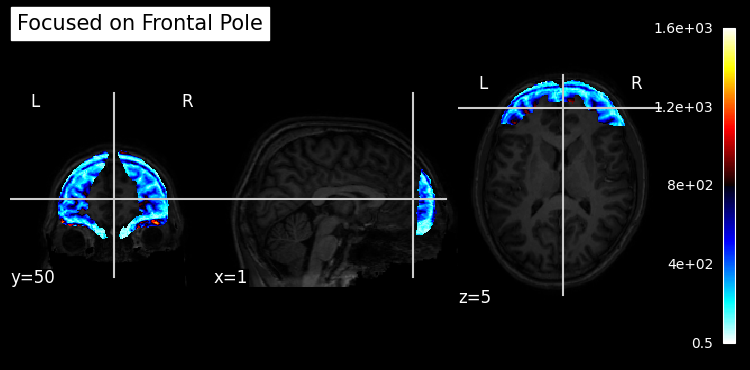

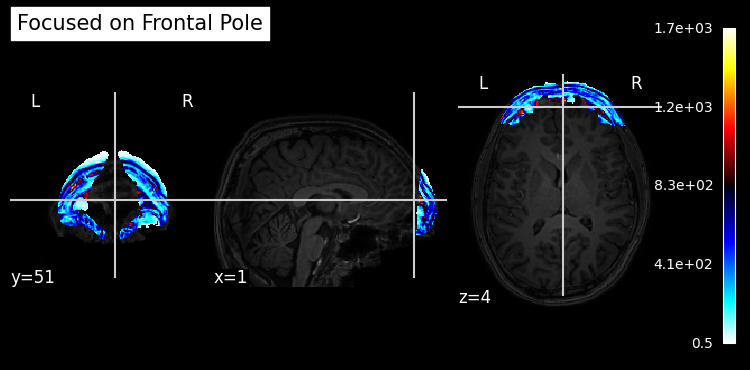

In [34]:
# Select a specific region by label
region_label = 'Frontal Pole'  # Replace with your region of interest
region_index = LABEL_NAMES.index(region_label)

# Remove the singleton dimension
region_mask = math_img('img == ' + str(region_index), img=ATLAS_IMAGE)

roi_stat_map = math_img("stat_map * mask", stat_map=baseLine, mask=region_mask)
plot_stat_map(roi_stat_map, bg_img=baseLine, title=f"Focused on {region_label}", threshold=0.5)

roi_stat_map = math_img("stat_map * mask", stat_map=followUp, mask=region_mask)
plot_stat_map(roi_stat_map, bg_img=followUp, title=f"Focused on {region_label}", threshold=0.5)


In [35]:
# Iterate through each region in the atlas
for region_index, region_label in enumerate(LABEL_NAMES):
    if region_label == "Background" or region_label == "Unknown Region":
        continue  # Skip background or unknown regions
    # Create the region mask
    region_mask = math_img(f'img == {region_index}', img=ATLAS_IMAGE)

    # Apply the mask to baseline and follow-up images
    baseline_region = math_img("stat_map * mask", stat_map=baseLine, mask=region_mask)
    followup_region = math_img("stat_map * mask", stat_map=followUp, mask=region_mask)

    # Calculate volumes for baseline and follow-up
    baseline_data = get_data(baseline_region) > 0  # Binary mask for the baseline
    followup_data = get_data(followup_region) > 0  # Binary mask for the follow-up

    baseline_voxel_count = np.sum(baseline_data)
    followup_voxel_count = np.sum(followup_data)

    # Calculate voxel volume
    voxel_sizes = np.abs(np.diag(ATLAS_IMAGE.affine)[:3])  # mm dimensions
    voxel_volume = np.prod(voxel_sizes)  # Volume of a single voxel in mm³

    # Total region volume in mm³
    baseline_volume = baseline_voxel_count * voxel_volume
    followup_volume = followup_voxel_count * voxel_volume

    # Print results
    if followup_volume - baseline_volume != 0:
        print(f"Volume difference {region_label}: {followup_volume - baseline_volume:.2f} mm³")

Volume difference Frontal Pole: -8311.00 mm³
Volume difference Superior Frontal Gyrus: -4.00 mm³
Volume difference Temporal Pole: -3.00 mm³
Volume difference Frontal Medial Cortex: -1.00 mm³
